In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import netCDF4 as nc4

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
print(f"netCDF4 version: {nc4.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"seaborn version: {sns.__version__}")

netCDF4 version: 1.6.4
xarray version: 2023.6.0
pandas version: 1.5.3
numpy version: 1.24.3
seaborn version: 0.12.2


In [4]:
station = ['44056', '44100', '44086']
station_info = ['Duck Inshore', 'Duck Offshore', 'Nags Head']
year = '2021'

def get_url(station, year):
  url = f"https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/"\
        f"{station}/{station}h{year}.nc"
  return url

url1 = get_url(station[0], year)
url2 = get_url(station[1], year)
url3 = get_url(station[2], year)

print(f"{url1}\n{url2}\n{url3}\n")

ncds1 = nc4.Dataset(url1)
ncds2 = nc4.Dataset(url2)
ncds3 = nc4.Dataset(url3)

https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44056/44056h2021.nc
https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44100/44100h2021.nc
https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44086/44086h2021.nc



In [5]:
ds1 = xr.open_dataset(url1)
ds1

<xarray.Dataset>
Dimensions:                  (time: 15902, latitude: 1, longitude: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-21T19:26:00 ... 20...
  * latitude                 (latitude) float32 36.2
  * longitude                (longitude) float32 -75.71
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_temperature        (time, latitude, longitude) float32 ...
    visibility               (time, latitude, longitude) float32 ...
    water_level              (time, latitude, longitude) float32 ...
Attributes:
    institution:                     NOAA National Data Buoy Center and Parti...
    url:                             http://dods.ndbc.noaa.gov
    quality:                         Automated QC checks with manual editing ...
    conventions:                     COARDS
    station:                         44056
    comment:                         Duck FRF, NC
    location:                        36.200 N 75.714 W 
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
ds2 = xr.open_dataset(url2)
ds3 = xr.open_dataset(url3)

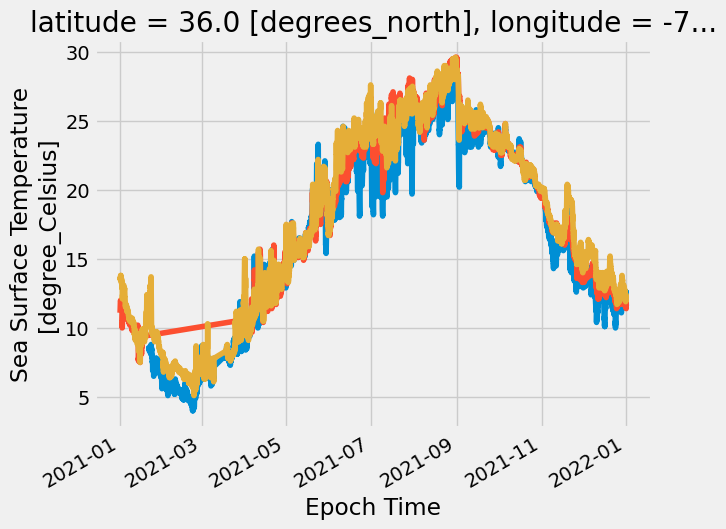

In [7]:
ds1.sea_surface_temperature.plot()
ds2.sea_surface_temperature.plot()
ds3.sea_surface_temperature.plot()

In [8]:
year = np.arange(2012, 2024)
year

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023])

Concatenate into a multi-year time series

In [9]:
url = get_url(station[0], year[0])
ds = xr.open_dataset(url)
SST = ds.sea_surface_temperature.squeeze()
time = ds.time
for n in enumerate(year[1::]):
  url = get_url(station[0], year[n[0]+1])
  ds = xr.open_dataset(url)
  SST2 = ds.sea_surface_temperature.squeeze()
  time2 = ds.time
  SST = xr.concat([SST, SST2], dim='time')
  time = xr.concat([time, time2], dim='time')

In [10]:
SST

<xarray.DataArray 'sea_surface_temperature' (time: 185152)>
array([12.3, 12.3, 12.3, ..., 19.3, 19.3, 19.3], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01T00:20:00 ... 2023-10-31T23:56:00
    latitude   float32 36.2
    longitude  float32 -75.71
Attributes:
    long_name:      Sea Surface Temperature
    short_name:     wtmp
    standard_name:  sea_surface_temperature
    units:          degree_Celsius

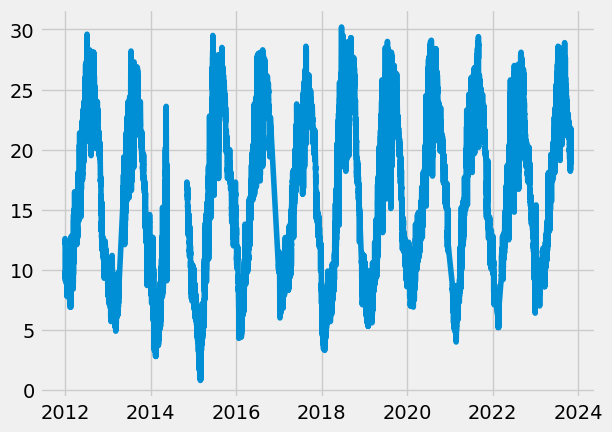

In [11]:
plt.plot(time, SST)

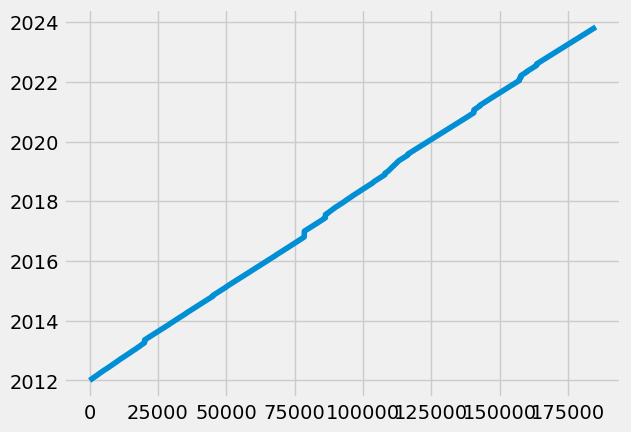

In [12]:
plt.plot(time)

Convert to a pandas dataframe

In [13]:
df = SST.to_dataframe()
df

,latitude,longitude,sea_surface_temperature
time,,,
2012-01-01 00:20:00,36.200001,-75.713997,12.300000
2012-01-01 00:50:00,36.200001,-75.713997,12.300000
2012-01-01 01:20:00,36.200001,-75.713997,12.300000
2012-01-01 01:50:00,36.200001,-75.713997,12.300000
2012-01-01 02:20:00,36.200001,-75.713997,12.300000
...,...,...,...
2023-10-31 21:56:00,36.200001,-75.713997,19.299999
2023-10-31 22:26:00,36.200001,-75.713997,19.299999
2023-10-31 22:56:00,36.200001,-75.713997,19.299999


In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
df.index

DatetimeIndex(['2012-01-01 00:20:00', '2012-01-01 00:50:00',
               '2012-01-01 01:20:00', '2012-01-01 01:50:00',
               '2012-01-01 02:20:00', '2012-01-01 02:50:00',
               '2012-01-01 03:20:00', '2012-01-01 03:50:00',
               '2012-01-01 04:20:00', '2012-01-01 04:50:00',
               ...
               '2023-10-31 19:26:00', '2023-10-31 19:56:00',
               '2023-10-31 20:26:00', '2023-10-31 20:56:00',
               '2023-10-31 21:26:00', '2023-10-31 21:56:00',
               '2023-10-31 22:26:00', '2023-10-31 22:56:00',
               '2023-10-31 23:26:00', '2023-10-31 23:56:00'],
              dtype='datetime64[ns]', name='time', length=185152, freq=None)

## Train/Test Split

In [16]:
train = df.loc[df.index < '01-01-2020'].dropna()
test = df.loc[df.index >= '01-01-2020'].dropna()

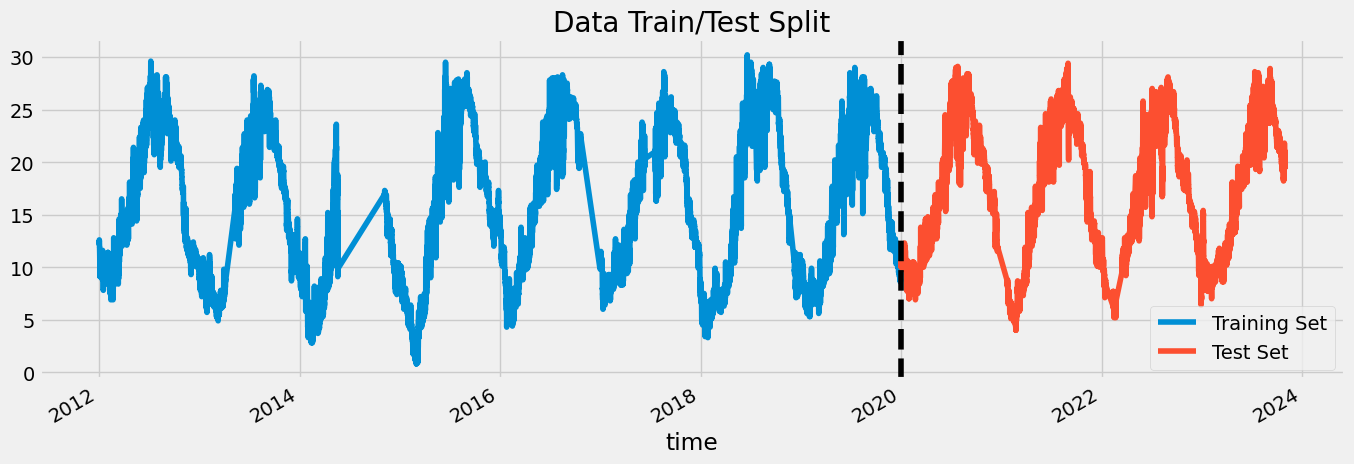

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
train.sea_surface_temperature.plot(
    ax=ax, label='Training Set', title='Data Train/Test Split')
test.sea_surface_temperature.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Feature Creation

In [18]:
def create_features(df):
  """
  Create time series features based on time series index.
  """
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

df = create_features(df)

In [19]:
df

,latitude,longitude,sea_surface_temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,,,,
2012-01-01 00:20:00,36.200001,-75.713997,12.300000,0,6,1,1,2012,1,1,52
2012-01-01 00:50:00,36.200001,-75.713997,12.300000,0,6,1,1,2012,1,1,52
2012-01-01 01:20:00,36.200001,-75.713997,12.300000,1,6,1,1,2012,1,1,52
2012-01-01 01:50:00,36.200001,-75.713997,12.300000,1,6,1,1,2012,1,1,52
2012-01-01 02:20:00,36.200001,-75.713997,12.300000,2,6,1,1,2012,1,1,52
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 21:56:00,36.200001,-75.713997,19.299999,21,1,4,10,2023,304,31,44
2023-10-31 22:26:00,36.200001,-75.713997,19.299999,22,1,4,10,2023,304,31,44
2023-10-31 22:56:00,36.200001,-75.713997,19.299999,22,1,4,10,2023,304,31,44


## Visualize our Feature/Target Relationship

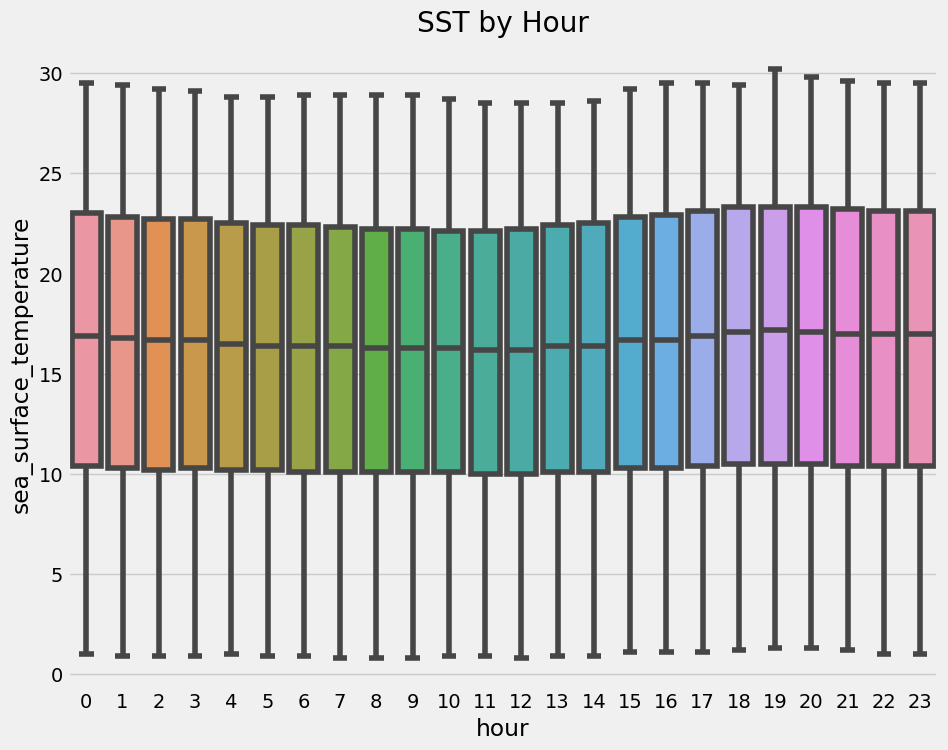

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='sea_surface_temperature')
ax.set_title('SST by Hour')
plt.show()

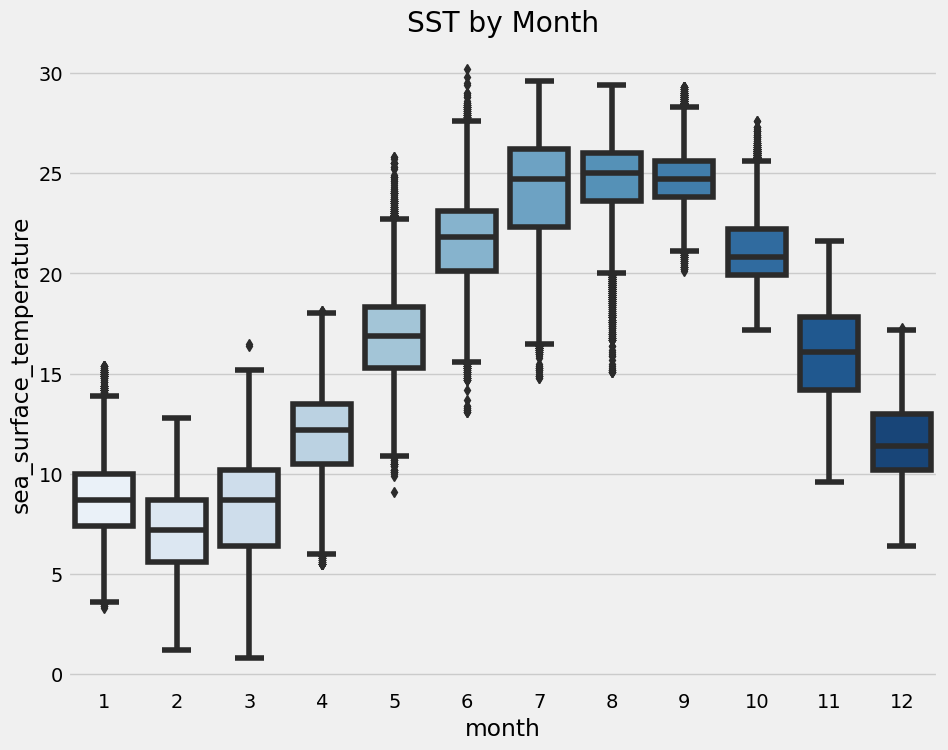

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='sea_surface_temperature', palette='Blues')
ax.set_title('SST by Month')
plt.show()

## Create Model

In [22]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sea_surface_temperature'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:16.81833	validation_1-rmse:17.75404
[100]	validation_0-rmse:6.47233	validation_1-rmse:6.92727
[200]	validation_0-rmse:2.96907	validation_1-rmse:3.17641
[300]	validation_0-rmse:1.98542	validation_1-rmse:2.15551
[400]	validation_0-rmse:1.74528	validation_1-rmse:1.91655
[500]	validation_0-rmse:1.67264	validation_1-rmse:1.88415
[600]	validation_0-rmse:1.63376	validation_1-rmse:1.88241
[625]	validation_0-rmse:1.62532	validation_1-rmse:1.88182


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

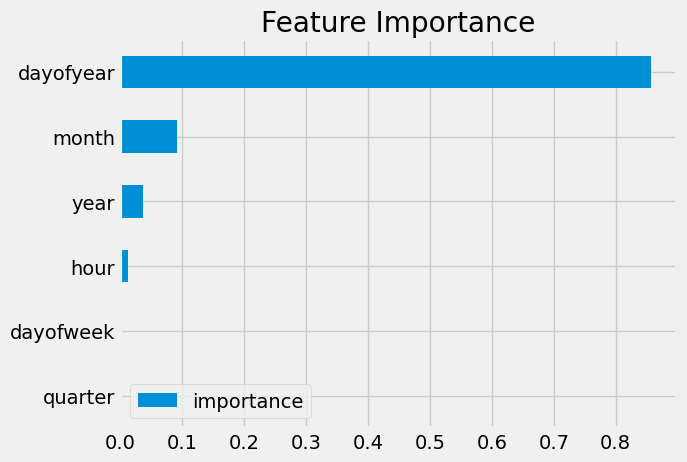

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

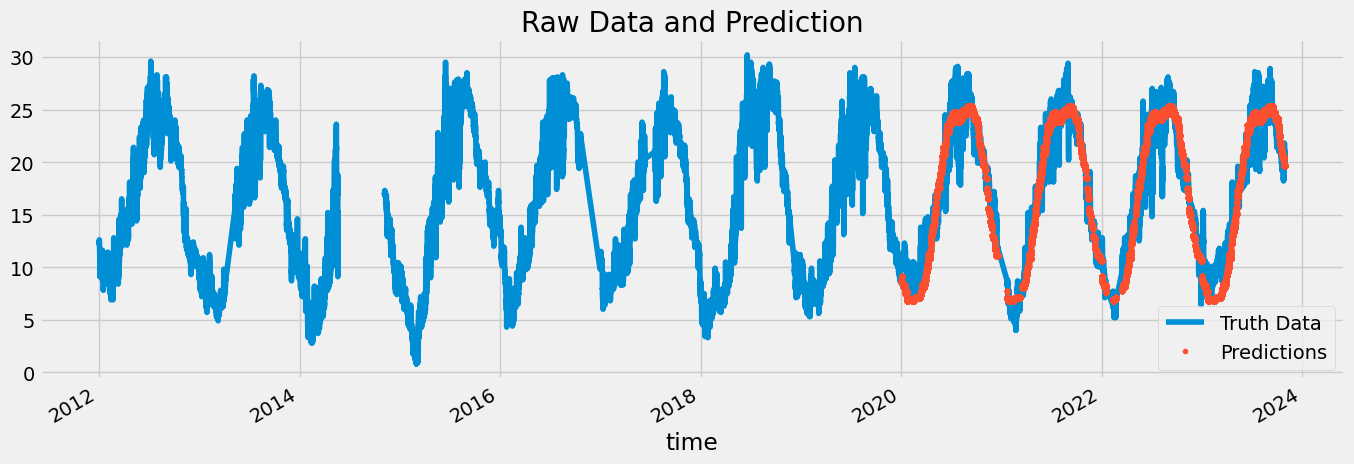

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(
    test[['prediction']],
    how='left',
    left_index=True,
    right_index=True)
ax = df[['sea_surface_temperature']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

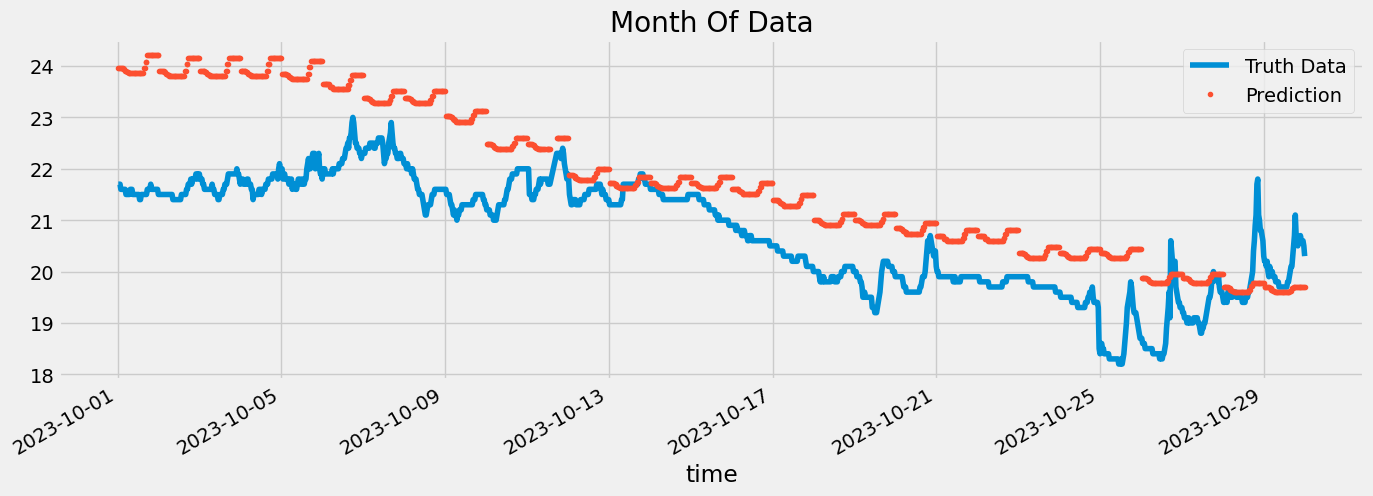

In [27]:
date1 = '10-01-2023'
date2 = '10-30-2023'
ax = df.loc[(df.index > date1) & (df.index < date2)]['sea_surface_temperature'] \
    .plot(figsize=(15, 5), title='Month Of Data')
df.loc[(df.index > date1) & (df.index < date2)]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [28]:
score = np.sqrt(mean_squared_error(test['sea_surface_temperature'],
                                   test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.88


In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-01-05    6.625881
2022-08-10    6.570259
2023-01-06    6.202963
2020-06-11    6.017512
2022-07-03    5.956263
2022-08-09    5.916092
2020-06-12    5.548762
2023-01-04    5.121714
2021-07-09    4.819899
2020-03-30    4.796797
Name: error, dtype: float32